In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
from tqdm import tqdm
import networkx as nx
from matplotlib_venn import venn2, venn3
from neteval import gene_mapper as gm
from neteval import query_ensembl as qe
from neteval import query_hgnc as qh
import obonet as obo
import random as rn

In [2]:
datadir='/cellar/users/snwright/Data/RareCommon/'
outdir='/cellar/users/snwright/Data/Transfer/RVC/'
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/RAVAR_GWASCat/'

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

In [4]:
with open(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/overlap_traits_Jun27.txt'), 'r') as f:
    overlap_traits = [x.strip() for x in f.readlines()]

# Identify testing traits

## Load Ontology

In [5]:
efo = obo.read_obo('http://www.ebi.ac.uk/efo/efo.obo')
efo_root='EFO:0000001'

In [ ]:
def assign_trait_to_global(trait, efo, high_level_terms=['EFO:0000408','EFO:0001444','HP:0000118']):
    trait = trait.replace('_', ':')
    high_level_parents = []
    if trait in efo.nodes:
        for ancestor in list(nx.descendants(efo, trait)):
            if ancestor in high_level_terms:
                high_level_parents.append(ancestor)
    else:
        print(trait, 'not in efo graph')
    return high_level_parents

def assign_trait_list_to_global(trait_list, efo, high_level_terms=['EFO:0000408','EFO:0001444','HP:0000118']):
    groups = {trait:[] for trait in high_level_terms}
    for trait in trait_list:
        parents = assign_trait_to_global(trait ,efo, high_level_terms=high_level_terms)
        try:
            for term in parents:
                groups[term].append(trait)
        except:
            print(parents)
    return groups

## Load and filter study info

In [ ]:
    gwas_study = pd.read_csv(os.path.join(datadir, 'GWASCatalog','trait_info_cleaned.txt'), sep='\t')

In [ ]:
gwas_study = gwas_study.loc[gwas_study['ASSOCIATION COUNT'] >= 1]
gwas_study.TRAIT_CODE.nunique()

In [ ]:
# keep those not in overlap
testing_studies = [t for t in gwas_study[~gwas_study['SUMMARY STATS LOCATION'].isna()].TRAIT_CODE.unique() if (t not in overlap_traits) and (t.replace('_', ':') not in overlap_traits)]

In [ ]:
# keep those with summary statistics
testing_study = gwas_study[gwas_study.TRAIT_CODE.isin(testing_studies) & ~gwas_study['SUMMARY STATS LOCATION'].isna()]

In [ ]:
# keep those with no background trait
testing_study = testing_study[testing_study['MAPPED BACKGROUND TRAIT URI'].isna()]

In [ ]:
# keep those with at least one association
testing_study = testing_study[testing_study['ASSOCIATION COUNT'] > 0]

In [ ]:
# look at the distribution of associations
testing_study['ASSOCIATION COUNT'].describe(percentiles=[0.75,0.8,0.85, 0.9, 0.95, 0.99])

In [ ]:
testing_study = testing_study[testing_study['ASSOCIATION COUNT'] >= 5]

In [ ]:
# map traits to EFO categories?
global_map = assign_trait_list_to_global(list(testing_study.TRAIT_CODE.unique()), efo)
# map disease categories
disease_map = assign_trait_list_to_global(global_map['EFO:0000408'],efo , [node for node in efo.predecessors( 'EFO:0000408')] )
# map measurement categories
measure_map = assign_trait_list_to_global(global_map['EFO:0001444'],efo, [node for node in efo.predecessors( 'EFO:0001444')] )
# map abnormality categories
abnorm_map = assign_trait_list_to_global(global_map['HP:0000118'],efo, [node for node in efo.predecessors( 'HP:0000118')] )

## Select traits

In [ ]:
import random as rn
def select_random_traits(trait_map):
    traits = []
    for k in trait_map.keys():
        n = len(trait_map[k])
        if n == 0:
            pass
        elif n == 1:
            traits += trait_map[k]
        else:
            n_select = min(1, int(n*0.1))
            traits += rn.sample(trait_map[k], n_select)
    return set(traits)
disease_traits = select_random_traits(disease_map)
measurement_traits = select_random_traits(measure_map)
abnorm_traits = select_random_traits(abnorm_map)
all_test_traits = disease_traits.union(measurement_traits).union(abnorm_traits)

In [ ]:
all_test_traits =[x.replace(':', '_') for x in list(all_test_traits)]
testing_study['Trait'] = testing_study.TRAIT_CODE.apply(lambda x: x.replace(':', '_'))
exclude = list(testing_df.Trait.value_counts()[(testing_df.Trait.value_counts() >= 10)].index)

In [ ]:
with open(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/testing/testing_gwas_traits_xxx.txt'), 'w') as f:
    for trait in all_test_traits:
        if trait not in exclude:
            f.write(trait + '\n')

In [ ]:
testing_df = testing_study[testing_study.Trait.isin(all_test_traits) & ~testing_study.Trait.isin(exclude)].drop_duplicates()
testing_df.to_csv('/cellar/users/snwright/Data/RareCommon/inputs/testing/testing_study_info_Dec3.txt', sep='\t')

In [ ]:
urls = list(testing_df['SUMMARY STATS LOCATION'].unique())

In [ ]:
with open(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/testing/testing_gwas_sumstats_urls_xxx.txt'), 'w') as f:
    for url in urls:
        f.write(url + '\n')

# Create Gene sets

### Identify unique trait-study pairs

In [4]:
testing_df = pd.read_csv('/cellar/users/snwright/Data/RareCommon/inputs/testing/testing_study_info_Dec3.txt', sep='\t', index_col=0)

In [5]:
studies = testing_df.drop_duplicates(subset=['DISEASE/TRAIT', 'ASSOCIATION COUNT', 'STUDY ACCESSION', 'COHORT', 'Trait'])

In [6]:
trait_study_pairs = [pair for pair in zip(studies.Trait, studies['STUDY ACCESSION'])]

In [7]:
trait_study_pairs

[('EFO_1001976', 'GCST005842'),
 ('EFO_1001976', 'GCST006910'),
 ('EFO_0006525', 'GCST007602'),
 ('EFO_0004741', 'GCST008062'),
 ('EFO_0004274', 'GCST001791'),
 ('EFO_0009797', 'GCST003143'),
 ('EFO_0005213', 'GCST90000654'),
 ('EFO_0010156', 'GCST010572'),
 ('EFO_0004608', 'GCST007367'),
 ('EFO_0004502', 'GCST010901'),
 ('EFO_0004458', 'GCST010901'),
 ('EFO_0004502', 'GCST010900'),
 ('EFO_0004458', 'GCST010900'),
 ('EFO_0010903', 'GCST90006890'),
 ('EFO_0004575', 'GCST009731'),
 ('EFO_0004274', 'GCST010637'),
 ('HP_0000225', 'GCST004198'),
 ('EFO_0005213', 'GCST009414'),
 ('EFO_0005213', 'GCST006366'),
 ('EFO_0007663', 'GCST002986'),
 ('EFO_0005213', 'GCST003856'),
 ('EFO_0009388', 'GCST004620'),
 ('EFO_0006501', 'GCST010536'),
 ('EFO_0006501', 'GCST010538'),
 ('EFO_0006501', 'GCST010537'),
 ('EFO_0006501', 'GCST010541'),
 ('EFO_0006501', 'GCST010540'),
 ('EFO_0006501', 'GCST010539'),
 ('EFO_0008399', 'GCST90003936'),
 ('EFO_0008399', 'GCST90003890'),
 ('EFO_0008399', 'GCST90003881'),

### Load association data

In [8]:
gwas_genes = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_cat_download_Jan22.txt.cleanedDec4'), sep="\t")

In [9]:
gwas_genes['logp'] = -1 * np.log10(gwas_genes['P-VALUE']+1e-300)

In [10]:
gwas_genes['Trait'] = gwas_genes.TRAIT_CODE.apply(lambda x: x.replace(':', '_'))

In [11]:
gwas_genes['trait_study'] = [pair for pair in zip(gwas_genes.Trait, gwas_genes['STUDY ACCESSION'])]

In [12]:
testing_genes = gwas_genes[gwas_genes.trait_study.isin(trait_study_pairs)]

### Load Entrez Mapping

In [13]:
converted_gwas_genes = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_cat_download_Jan22.txt.cleanedJun17.entrez'), 
                                   sep="\t", usecols = ['MAPPED_GENE', 'Entrez']).drop_duplicates()

In [14]:
gene_map = converted_gwas_genes.set_index('MAPPED_GENE').Entrez.to_dict()

In [15]:
testing_genes = testing_genes.assign(Entrez=testing_genes.MAPPED_GENE.map(gene_map))

In [16]:
testing_genes.head()

,PUBMEDID,DATE,DISEASE/TRAIT,MAPPED_GENE,SNP_GENE_IDS,INTERGENIC,P-VALUE,OR or BETA,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,TRAIT_CODE,logp,Trait,trait_study,Entrez
9167,30239722,2018-09-14,Waist-hip ratio,ADAMTS9-AS2,ENSG00000241684,0.0,5.000000e-15,0.0320,waist-hip ratio,http://www.ebi.ac.uk/efo/EFO_0004343,GCST008996,EFO_0004343,14.301030,EFO_0004343,"(EFO_0004343, GCST008996)",100507098
9168,30239722,2018-09-14,Waist-hip ratio,CDKAL1,ENSG00000145996,0.0,7.000000e-11,0.0125,waist-hip ratio,http://www.ebi.ac.uk/efo/EFO_0004343,GCST008996,EFO_0004343,10.154902,EFO_0004343,"(EFO_0004343, GCST008996)",54901
9169,30239722,2018-09-14,Waist-hip ratio,ZMIZ1,ENSG00000108175,0.0,3.000000e-14,0.0133,waist-hip ratio,http://www.ebi.ac.uk/efo/EFO_0004343,GCST008996,EFO_0004343,13.522879,EFO_0004343,"(EFO_0004343, GCST008996)",57178
9170,30239722,2018-09-14,Waist-hip ratio,ANAPC10,ENSG00000164162,0.0,8.000000e-13,0.0123,waist-hip ratio,http://www.ebi.ac.uk/efo/EFO_0004343,GCST008996,EFO_0004343,12.096910,EFO_0004343,"(EFO_0004343, GCST008996)",10393
9171,30239722,2018-09-14,Waist-hip ratio,LASTR,ENSG00000242147,0.0,9.000000e-10,0.0109,waist-hip ratio,http://www.ebi.ac.uk/efo/EFO_0004343,GCST008996,EFO_0004343,9.045757,EFO_0004343,"(EFO_0004343, GCST008996)",105376382


## Binary/Quant - nearestGene

In [17]:
def create_gene_set_profile(gene_data, trait_study,keep_cols=['MAPPED_GENE', 'P-VALUE', 'OR or BETA', 'Entrez'], p_th=1e-2):
    trait_data = gene_data.loc[gene_data.trait_study==trait_study, keep_cols]
    trait_data = trait_data[trait_data['P-VALUE']<=p_th]
    trait_data = trait_data.rename(columns = {'MAPPED_GENE':'Gene Symbol', 'P-VALUE':'P-value', 'OR or BETA': 'ORB'})
    trait_data = trait_data.sort_values(by='P-value').drop_duplicates(subset=['Entrez'], keep='first')
    return trait_data

def split_gene_set_profile(gene_profile):
    n = len(gene_profile)
    set1_idx = rn.sample([i for i in range(n)], n//2)
    set2_idx = [i for i in range(n) if i not in set1_idx]
    return gene_profile.iloc[set1_idx].sort_values(by='P-value'), gene_profile.iloc[set2_idx].sort_values(by='P-value')

In [18]:
13//2

6

In [19]:
testing_genes.logp.describe()

count    1764.000000
mean       16.498541
std        25.165604
min         5.000000
25%         7.698970
50%        10.301030
75%        15.221849
max       300.000000
Name: logp, dtype: float64

In [20]:
binary_sets = {t: testing_genes[testing_genes.trait_study==t].Entrez.unique() for t in trait_study_pairs}

In [21]:
final_binary_sets = {t: binary_sets[t] for t in binary_sets if len(binary_sets[t])>=6}
len(final_binary_sets)

51

In [131]:
'_'.join(('asd', 'asdfa'))

'asd_asdfa'

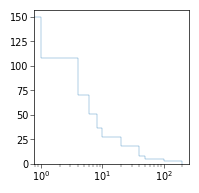

In [22]:
_= plt.figure(figsize=(2,2))
plt.hist([len(x) for x in binary_sets.values()], bins=[0,1,4,6,8,10,20,40,50,100,200], cumulative=-1, histtype='step')
plt.xscale('log')

In [24]:
file_names = []
for t in list(final_binary_sets.keys()):
    cv, rv = split_gene_set_profile(create_gene_set_profile(testing_genes, t))
    prefix = 'nearestGene_' + '_'.join(t)
    file_names.append(prefix)
    cv.to_csv(os.path.join(datadir, 'inputs/testing/testing3', f'{prefix}_CV.txt'), sep='\t', index=False)
    rv.to_csv(os.path.join(datadir, 'inputs/testing/testing3', f'{prefix}_RV.txt'), sep='\t', index=False)
with open(os.path.join(datadir, 'inputs/testing/testing3', 'nearestGene.traitlist'), 'w') as f:
    f.write('\n'.join(file_names)+'\n')

What if I also include a threshold?

In [97]:
binary_sets_th = {t: testing_genes[(testing_genes.trait_study==t)&(testing_genes.logp>=8)].Entrez.unique() for t in trait_study_pairs}

In [138]:
final_binary_sets_th = {t: binary_sets_th[t] for t in binary_sets_th if len(binary_sets_th[t])>=6}
len(final_binary_sets_th)

31

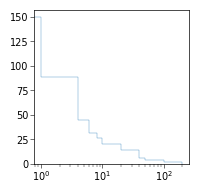

In [99]:
_= plt.figure(figsize=(2,2))
plt.hist([len(x) for x in binary_sets_th.values()], bins=[0,1,4,6,8,10,20,40,50,100,200], cumulative=-1, histtype='step')
plt.xscale('log')

In [140]:
file_names = []
for t in list(final_binary_sets_th.keys()):
    cv, rv = split_gene_set_profile(create_gene_set_profile(testing_genes, t, p_th=1e-8))
    prefix = 'nearestGeneTH8_' + '_'.join(t)
    file_names.append(prefix)
    cv.to_csv(os.path.join(datadir, 'inputs/testing', f'{prefix}_CV.txt'), sep='\t', index=False)
    rv.to_csv(os.path.join(datadir, 'inputs/testing', f'{prefix}_RV.txt'), sep='\t', index=False)
with open(os.path.join(datadir, 'inputs/testing', 'nearestGeneTH8.traitlist'), 'w') as f:
    f.write('\n'.join(file_names)+'\n')

## Quant, PASCAL -all

## Quant, PASCAL - threshold

# Overlap QTesting genelists

In [4]:
datadir = '/cellar/users/snwright/Data/RareCommon/inputs/overlap'

In [5]:
with open(os.path.join(datadir, 'nearestGene.traitlist'), 'r') as f:
    traits = [x.strip() for x in f.readlines()]

In [17]:
np.floor(len(rv)*level/2)

1.0

In [56]:
overlap_levels = [0.1, 0.25, 0.5, 0.75, 0.9]
for t in traits:
    cv = pd.read_csv(os.path.join(datadir, t+'_CV.txt'), sep='\t')
    rv = pd.read_csv(os.path.join(datadir, t+'_RV.txt'), sep='\t')
    if (len(rv) < 5) or (len(cv)<5):
        next
    else:
        for level in overlap_levels:
            r_shared = np.random.choice(rv.Entrez.values, int(np.floor(len(rv)*level)), replace=False)
            c_shared = np.random.choice(cv.Entrez.values, int(np.floor(len(cv)*level)), replace=False)
            if (len(r_shared) > 0) and (len(c_shared) > 0):
                if len(r_shared) < len(rv) and len(c_shared) < len(cv):
                    c_all = pd.concat([cv, rv[rv.Entrez.isin(r_shared)]])
                    r_all = pd.concat([rv, cv[cv.Entrez.isin(c_shared)]])
                    c_all.to_csv(os.path.join(datadir, f'{t}_{level}_CV.txt'), sep='\t')
                    r_all.to_csv(os.path.join(datadir, f'{t}_{level}_RV.txt'), sep='\t')
        

In [54]:
            r_shared = np.random.choice(rv.Entrez.values, int(np.floor(len(rv)*level)), replace=False)
            c_shared = np.random.choice(cv.Entrez.values, int(np.ceil(len(rv)*level)), replace=False)